In [ ]:
from datasets import load_dataset

import requests
from bs4 import BeautifulSoup

from collections import Counter
from itertools import chain

In [ ]:
"""
Function to remove a key from a dictionary

Parameters
----------
source : dict
  The dictionary to remove the key from
key : str
  The key to remove

Returns
-------
dict
  The dictionary without the key
"""

def remove_key(source: str, key):
  d = source
  del d[key]
  return d

In [ ]:
path = "UNDP/sdgi-corpus"

### Obtain labels from the UN website

In [ ]:
id2label = {}
url = "https://www.un.org/sustainabledevelopment/sustainable-development-goals/"

# This is so the request doesnt get blocked
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, 'html.parser')

    # The relevant element as found in the HTML code
    goals = soup.find_all('h2', class_='flip-box-heading')

    # Start at 1 since dataset labels start at 1
    i=1
    for item in goals:
        # Extract the text (e.g., "Goal 1: No Poverty")
        text = item.get_text(strip=True)

        if text.startswith("Goal"):
          id2label[i] = text

        i+=1

except Exception as e:
    print(f"An error occurred: {e}")

### Pre-process the dataset

In [ ]:
dataset = load_dataset(path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/28.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5880 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1470 [00:00<?, ? examples/s]

In [ ]:
dataset = (dataset
              .map(lambda x: remove_key(x, "embedding"))                      # Remove the pre-defined embeddings
              .map(lambda x: {"labels": [id2label[i] for i in x["labels"]]})  # Change number labels to text
          )

Map:   0%|          | 0/5880 [00:00<?, ? examples/s]

Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

Map:   0%|          | 0/5880 [00:00<?, ? examples/s]

Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

### EDA

In [ ]:
counts = Counter(chain.from_iterable(dataset['train']['labels']))

print(counts)

Counter({'Goal 11: Sustainable Cities and Communities': 626, 'Goal 3: Good Health and Well-Being': 578, 'Goal 17: Partnerships': 570, 'Goal 8: Decent Work and Economic Growth': 548, 'Goal 4: Quality Education': 532, 'Goal 13: Climate Action': 519, 'Goal 5: Gender Equality': 487, 'Goal 10: Reduced Inequalities': 485, 'Goal 16: Peace, Justice and Strong Institutions': 485, 'Goal 9: Industry, Innovation, and Infrastructure': 467, 'Goal 12: Responsible Consumption and Production': 458, 'Goal 1: No Poverty': 452, 'Goal 2: Zero Hunger': 437, 'Goal 7: Affordable and Clean Energy': 420, 'Goal 15: Life on Land': 404, 'Goal 6: Clean Water and Sanitation': 395, 'Goal 14: Life Below Water': 299})


In [ ]:
def count_labels(data):
    labels_column = data['labels']

    multiple_labels = sum(1 for tags in labels_column if len(tags) > 1)
    single_labels = sum(1 for tags in labels_column if len(tags) == 1)
    empty_labels = sum(1 for tags in labels_column if len(tags) == 0)

    return {
        'single labels': single_labels,
        'multiple labels': multiple_labels,
        'empty labels': empty_labels
    }

count_labels(dataset['train'])

{'single labels': 5233, 'multiple labels': 647, 'empty labels': 0}

In [ ]:
def label_combinations(data):
# if a data point has multiple labels, how many and which combinations
  mult_label_lengths = {}
  label_combinations = {}

  for item in data:
    if len(item['labels']) > 1:
      mult_label_lengths[len(item['labels'])] = mult_label_lengths.get(len(item['labels']), 0) + 1
      # This needs to be a string to be a dictionary key (hashable)
      label_combinations[str(item['labels'])] = label_combinations.get(str(item['labels']), 0) + 1

  return {'multiple label lengths': mult_label_lengths,
          'label combinations': label_combinations}

label_combinations(dataset['train'])

{'multiple label lengths': {2: 137,
  7: 34,
  8: 17,
  10: 13,
  17: 8,
  11: 6,
  13: 1,
  4: 146,
  5: 98,
  12: 4,
  3: 132,
  6: 33,
  15: 6,
  14: 3,
  9: 8,
  16: 1},
 'label combinations': {"['Goal 1: No Poverty', 'Goal 2: Zero Hunger']": 2,
  "['Goal 8: Decent Work and Economic Growth', 'Goal 12: Responsible Consumption and Production']": 1,
  "['Goal 1: No Poverty', 'Goal 3: Good Health and Well-Being', 'Goal 9: Industry, Innovation, and Infrastructure', 'Goal 10: Reduced Inequalities', 'Goal 11: Sustainable Cities and Communities', 'Goal 16: Peace, Justice and Strong Institutions', 'Goal 17: Partnerships']": 1,
  "['Goal 1: No Poverty', 'Goal 2: Zero Hunger', 'Goal 3: Good Health and Well-Being', 'Goal 4: Quality Education', 'Goal 5: Gender Equality', 'Goal 8: Decent Work and Economic Growth', 'Goal 9: Industry, Innovation, and Infrastructure', 'Goal 17: Partnerships']": 1,
  "['Goal 2: Zero Hunger', 'Goal 3: Good Health and Well-Being', 'Goal 4: Quality Education', 'Goal 5:

In [ ]:
# Calculate correlation between labels

Language breakdown

In [ ]:
language_count = Counter(item['metadata']['language'] for item in dataset['train'])

In [ ]:
language_count

Counter({'en': 4225, 'es': 935, 'fr': 720})

In [ ]:
languages = ['en', 'es', 'fr']
language_datasets = {
    lang: dataset['train'].filter(lambda x: x['metadata']['language'] == lang)
    for lang in languages
}

Filter:   0%|          | 0/5880 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5880 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5880 [00:00<?, ? examples/s]

In [ ]:
print('English: ', count_labels(language_datasets['en'])) # 13 perct
print('Spanish: ', count_labels(language_datasets['es'])) # 18 perct
print('French: ', count_labels(language_datasets['fr'])) # 2 perct

English:  {'single labels': 3743, 'multiple labels': 482, 'empty labels': 0}
Spanish:  {'single labels': 790, 'multiple labels': 145, 'empty labels': 0}
French:  {'single labels': 700, 'multiple labels': 20, 'empty labels': 0}


In [ ]:
print('English: ', label_combinations(language_datasets['en']))
print('Spanish: ', label_combinations(language_datasets['es']))
print('French: ', label_combinations(language_datasets['fr']))

English:  {'multiple label lengths': {5: 75, 7: 24, 10: 9, 3: 105, 4: 109, 6: 20, 2: 109, 17: 5, 15: 3, 14: 2, 9: 5, 8: 10, 11: 4, 12: 2}, 'label combinations': {"['Goal 3: Good Health and Well-Being', 'Goal 9: Industry, Innovation, and Infrastructure', 'Goal 11: Sustainable Cities and Communities', 'Goal 12: Responsible Consumption and Production', 'Goal 13: Climate Action']": 1, "['Goal 7: Affordable and Clean Energy', 'Goal 8: Decent Work and Economic Growth', 'Goal 9: Industry, Innovation, and Infrastructure', 'Goal 10: Reduced Inequalities', 'Goal 11: Sustainable Cities and Communities', 'Goal 12: Responsible Consumption and Production', 'Goal 13: Climate Action']": 1, "['Goal 3: Good Health and Well-Being', 'Goal 6: Clean Water and Sanitation', 'Goal 8: Decent Work and Economic Growth', 'Goal 9: Industry, Innovation, and Infrastructure', 'Goal 10: Reduced Inequalities', 'Goal 11: Sustainable Cities and Communities', 'Goal 12: Responsible Consumption and Production', 'Goal 13: Cli

Label correlation

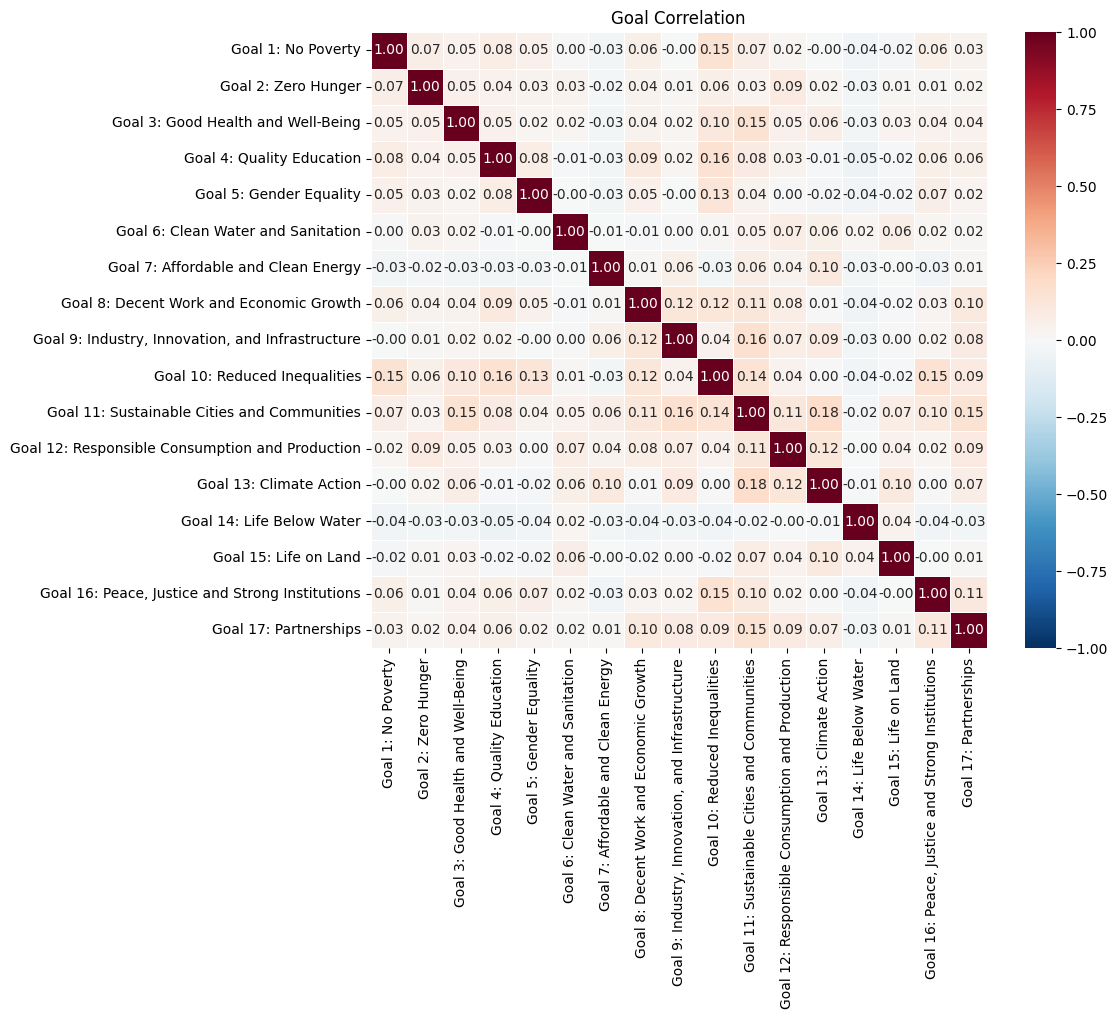

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

def natural_sort_key(s):
    # Splits 'tag10' into ['tag', 10] so '2' comes before '10'
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(dataset['train']['labels'])

df = pd.DataFrame(binary_matrix, columns=mlb.classes_)
sorted_cols = sorted(df.columns, key=natural_sort_key)
df = df[sorted_cols]

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='RdBu_r',
    center=0,      # White is exactly 0
    vmin=-1,       # Fixed scale lower bound
    vmax=1,        # Fixed scale upper bound
    square=True,
    linewidths=.5
)

plt.title('Goal Correlation')
plt.savefig('natural_sorted_heatmap.png')